In [55]:
import ROOT
import math
# Colors
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from root_numpy import root2array, tree2array
from root_numpy import testdata, fill_hist
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (recall_score,  precision_score, f1_score, roc_auc_score, precision_recall_curve,
                             make_scorer, confusion_matrix, accuracy_score, roc_curve)
from keras import backend as K

import warnings
warnings.filterwarnings('ignore')

## Previous Analysis

Checking amount of signal and background events in all of the configurations formed by region, tag and signal type.

#### Add new column with signal label

In [57]:
# If the row sample is 'Xtohh1000' or 'Xtohh2000', then the new columns will have a 1 in this row.
def classifier(row):
    if row['sample'] == 'Xtohh1000':
        return 1
    #else if row['sample'] == 'Xtohh2000':
    #    return 1
    else:
        return 0

In [58]:
# Select rows different of data samples
# Select rows on the SR_1tag region
def sel_df(df, region):
    df = df[(df['sample']!='data') & (df['m_region']==region)]
    df["signal"] = df.apply(classifier, axis=1)
    return df

In [59]:
def print_configs():
    print('%-15s%-10s%-10s%-10s' % ("Region", "Xtohh", "Signal", "Bkg"))
    for sig in [1000,2000]:
        rfile = ROOT.TFile("/home/andrea/Escritorio/CERN data/Try3/all_"+str(sig)+".root")
        intree = rfile.Get("Nominal")
        array = tree2array(intree)
        df = pd.DataFrame(array)
        for reg in np.unique(df['m_region'].values):
            df_aux = sel_df(df, reg)
            bkg = df_aux["signal"].value_counts().values[0]
            signal = df_aux["signal"].value_counts().values[1]
            print('%-15s%-10i%-10i%-10i' % (reg, sig, signal, bkg))
    return

##### Run once

In [22]:
print_configs()

Region         Xtohh     Signal    Bkg       
PreSel_0tag    1000      2550      98061     
PreSel_1tag    1000      4681      16467     
PreSel_2tag    1000      995       4343      
QCDCR_0tag     1000      557       38603     
QCDCR_1tag     1000      1128      7205      
QCDCR_2tag     1000      556       1166      
SR_0tag        1000      1993      59458     
SR_1tag        1000      3553      9262      
SR_2tag        1000      439       3177      
PreSel_0tag    2000      2867      98061     
PreSel_1tag    2000      11507     16467     
PreSel_2tag    2000      995       13720     
QCDCR_0tag     2000      544       38603     
QCDCR_1tag     2000      2152      7205      
QCDCR_2tag     2000      556       2271      
SR_0tag        2000      2323      59458     
SR_1tag        2000      9262      9355      
SR_2tag        2000      439       11449     


## Import ROOT file

You can either import a file which includes both Xtohh1000 and Xtohh2000 signal events, but their samples must be different or import just the file which includes one of the signals and the background.

In [60]:
rfile = ROOT.TFile("/home/andrea/Escritorio/CERN data/Try3/all_1000.root")
intree = rfile.Get("Nominal")
array = tree2array(intree)
df = pd.DataFrame(array)
df = sel_df(df, "SR_1tag")

# Delete columns
not_cons = ['sample', 'EventWeight', 'EventNumber', 'm_region', 'm_FJNbtagJets', 'm_FJphi', 'm_FJeta', 'm_DTeta', 'm_DTphi']
df.drop(not_cons, axis=1, inplace=True)

## Dividing data for training and testing

In [61]:
# Features
feature_cols = df.columns.values[:-1]

X = df.loc[:, feature_cols].values
# Targets
y = df['signal'].values

#from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler(random_state=0)
#X_resampled, y_resampled = ros.fit_resample(X, y)

from imblearn.over_sampling import SMOTE, ADASYN
#https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)


print("Training size:",X_train.shape[0])
print("Test size:", X_test.shape[0])
values, counts = np.unique(y, return_counts=True)
print("Signal amount:", counts[1],",", round(counts[1]/y.shape[0], 2),"%")
print("Background amount:", counts[0],",", round(counts[0]/y.shape[0], 2),"%")

Training size: 14770
Test size: 2563
Signal amount: 3553 , 0.28 %
Background amount: 9262 , 0.72 %


In [62]:
values_s, count_s = np.unique(y_train, return_counts=True)
print("Signal training events:", count_s[1],",", round(count_s[1]/X_train.shape[0], 2),"%")
print("Background training events:", count_s[0],",", round(count_s[0]/X_train.shape[0],2),"%")
values_b, count_b = np.unique(y_test, return_counts=True)
print("Signal testing events:", count_b[1],",", round(count_b[1]/X_test.shape[0],2),"%")
print("Background testing events:", count_b[0],",", round(count_b[0]/X_test.shape[0],2),"%")

Signal training events: 7385 , 0.5 %
Background training events: 7385 , 0.5 %
Signal testing events: 686 , 0.27 %
Background testing events: 1877 , 0.73 %


## Custom metric: F1

In [63]:
def f1_(y_true, y_pred):
    def recall_(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision_(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision_(y_true, y_pred)
    recall = recall_(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Configure neural network

In [70]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(100, activation='relu', kernel_initializer='uniform', input_dim=10))
classifier.add(Dropout(rate= 0.1))
#Second  Hidden Layer
classifier.add(Dense(100, activation='relu', kernel_initializer='uniform'))
classifier.add(Dropout(rate= 0.1))
#Third  Hidden Layer
classifier.add(Dense(100, activation='relu', kernel_initializer='uniform'))
classifier.add(Dropout(rate= 0.1))
#Fourth Hidden Layer
classifier.add(Dense(100, activation='relu', kernel_initializer='uniform'))
classifier.add(Dropout(rate= 0.1))
#Fifth Hidden Layer
classifier.add(Dense(100, activation='relu', kernel_initializer='uniform'))
classifier.add(Dropout(rate= 0.1))
#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='uniform'))

In [71]:
#Compiling the neural network
classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =[f1_])

In [72]:
#Fitting the data to the training dataset
classifier.fit(X_train,y_train, batch_size=50, epochs=200)

Epoch 1/200
14770/14770 [==============================] - 2s 163us/step - loss: 0.6696 - f1_: 0.6498
Epoch 2/200
14770/14770 [==============================] - 2s 111us/step - loss: 0.6414 - f1_: 0.6826
Epoch 3/200
14770/14770 [==============================] - 2s 109us/step - loss: 0.6322 - f1_: 0.6846
Epoch 4/200
14770/14770 [==============================] - 2s 120us/step - loss: 0.5970 - f1_: 0.7059
Epoch 5/200
14770/14770 [==============================] - 2s 111us/step - loss: 0.5823 - f1_: 0.7182
Epoch 6/200
14770/14770 [==============================] - 2s 113us/step - loss: 0.5689 - f1_: 0.7250
Epoch 7/200
14770/14770 [==============================] - 2s 118us/step - loss: 0.5565 - f1_: 0.7306
Epoch 8/200
14770/14770 [==============================] - 2s 132us/step - loss: 0.5531 - f1_: 0.7381
Epoch 9/200
14770/14770 [==============================] - 1s 100us/step - loss: 0.5510 - f1_: 0.7376
Epoch 10/200
14770/14770 [==============================] - 2s 105us/step - loss: 

14770/14770 [==============================] - 3s 172us/step - loss: 0.5264 - f1_: 0.7635
Epoch 81/200
14770/14770 [==============================] - 2s 150us/step - loss: 0.5231 - f1_: 0.7643
Epoch 82/200
14770/14770 [==============================] - 2s 158us/step - loss: 0.5247 - f1_: 0.7658
Epoch 83/200
14770/14770 [==============================] - 2s 145us/step - loss: 0.5437 - f1_: 0.7554
Epoch 84/200
14770/14770 [==============================] - 2s 136us/step - loss: 0.5240 - f1_: 0.7657
Epoch 85/200
14770/14770 [==============================] - 2s 133us/step - loss: 0.5219 - f1_: 0.7667
Epoch 86/200
14770/14770 [==============================] - 3s 174us/step - loss: 0.5263 - f1_: 0.7654
Epoch 87/200
14770/14770 [==============================] - 3s 174us/step - loss: 0.5221 - f1_: 0.7683
Epoch 88/200
14770/14770 [==============================] - 2s 133us/step - loss: 0.5220 - f1_: 0.7681
Epoch 89/200
14770/14770 [==============================] - 2s 143us/step - loss: 0.52

14770/14770 [==============================] - 3s 182us/step - loss: 0.5224 - f1_: 0.7501
Epoch 160/200
14770/14770 [==============================] - 2s 166us/step - loss: 0.5221 - f1_: 0.7475
Epoch 161/200
14770/14770 [==============================] - 4s 243us/step - loss: 0.5191 - f1_: 0.7448
Epoch 162/200
14770/14770 [==============================] - 3s 180us/step - loss: 0.5085 - f1_: 0.7508
Epoch 163/200
14770/14770 [==============================] - 3s 174us/step - loss: 0.5717 - f1_: 0.7270
Epoch 164/200
14770/14770 [==============================] - 3s 232us/step - loss: 0.5592 - f1_: 0.7477
Epoch 165/200
14770/14770 [==============================] - 4s 278us/step - loss: 0.5506 - f1_: 0.7591
Epoch 166/200
14770/14770 [==============================] - 3s 200us/step - loss: 0.5313 - f1_: 0.7559
Epoch 167/200
14770/14770 [==============================] - 3s 230us/step - loss: 0.5395 - f1_: 0.7463
Epoch 168/200
14770/14770 [==============================] - 3s 195us/step - l

0.846127978552712

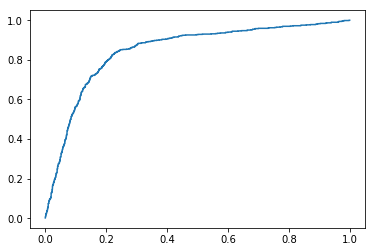

In [73]:
y_pred_prob = classifier.predict(X_test)
y_pred = (y_pred_prob>0.5)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
plt.plot(fpr, tpr)
roc_auc_score(y_test, y_pred_prob)


In [74]:
r = recall_score(y_test,y_pred)
p = precision_score(y_test,y_pred)
a = accuracy_score(y_test,y_pred)

print("recall:", r)
print("precision:", p)
print("accuracy:", a)

recall: 0.922740524781341
precision: 0.4282814614343708
accuracy: 0.649629340616465


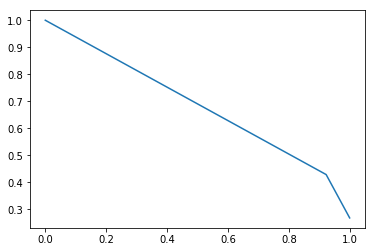

In [75]:
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)

In [76]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1032  845]
 [  53  633]]


In [77]:
y_test[:20]

array([1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

In [78]:
y_pred[:20]
aux = np.concatenate(y_pred[:20])
1*aux

array([1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

## TO DO:

- Ver método de oversampling debido al desbalanceo de los datos. Un método típico es el SMOTE.
- Hacer una tabla resumen de las configuraciones de región y señal, para generar los modelos de entrenamiento, contar la cantidad de señal y background en cada configuración.
- Usar f1 de HER2 como métrica de entrenamiento.